In [45]:
import numpy
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics.cluster import adjusted_rand_score

from tslearn.clustering import KShape
from tslearn.datasets import CachedDatasets
from tslearn.preprocessing import TimeSeriesScalerMeanVariance

import sys
import numpy as np
import yaml
from typing import Dict
from tqdm import tqdm

from adase.utils.pandas import read_df
from adase.utils.files import (directory_path,
                                get_raw_file,
                                get_all_files)
from adase.utils.pandas import write_df, read_df

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set(style="darkgrid")

In [5]:
def config(path) -> Dict:
    with open("{}config.yml".format(path), 'r') as ymlfile:
            cfg = yaml.load(ymlfile)
    return cfg

def download_dataset(cfg:Dict):
    
    raw_path = cfg.get('dataset').get('path_read_input')
    for file in tqdm(cfg.get('makedataset').get('files')):
        get_raw_file(raw_path, file)

def load_dataset(cfg:Dict):
    
    raw_path = cfg.get('dataset').get('path_read_input')
    
    dict_data: Dict = dict()

    for key, val in read_df(get_all_files(raw_path)).items():

        df_tmp = val.rename(columns={
                    'item': 'item_code',
                    'quantity_ecd': 'quantity',
                    'parent_item': 'parent_item_code',
                    'parent_quantity_ecd': 'parent_quantity'
                })

        if 'rpd' in df_tmp:
            first_element = sorted(df_tmp['rpd'].unique())[0]
            if first_element/1 != 1:
                df_tmp['rpd'] = df_tmp['rpd'] - (first_element-1)

        dict_data.update({key: df_tmp})
                
    return dict_data

cfg = config('../')
download_dataset(cfg)
data_dicts = load_dataset(cfg)

100%|██████████| 9/9 [00:00<00:00, 80.47it/s]


In [6]:
data_series = data_dicts.get('demand_out_encoded_stage_3')\
.set_index(['item_code', 'rpd','future_flag'])\
.sort_index().unstack("rpd", fill_value=0).fillna(0).values

mu, sigma = 0, 0.1 
#[:600]
#data = np.log1p(
data = np.log1p(data_series[:]) + np.abs(np.random.normal(mu, sigma, size=data_series.shape))

In [51]:
def plot_data(ks, X_train, y_pred, sz, n_clusters=3):
    
    plt.figure(figsize=(12,25))
    for yi in range(n_clusters):
        plt.subplot(n_clusters, 1, 1 + yi)
        for xx in X_train[y_pred == yi]:
            #, alpha=.2
            plt.plot(xx.ravel(), "k-")
            #, 
        plt.plot(ks.cluster_centers_[yi].ravel(), "r-")
        plt.xlim(0, sz)
        #plt.ylim(-4, 4)
        plt.title("Cluster %d" % (yi + 1))

    plt.tight_layout()
    plt.show()
    
def split_train_test(X, y, size):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=size)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=size)
    
    return X_train, X_val, X_test, y_train, y_val, y_test
    
def normalize_data(data):
    numpy.random.shuffle(data)
    X_train = TimeSeriesScalerMeanVariance().fit_transform(data_series)
    sz = X_train.shape[1]
    
    return X_train, sz

def k_means(data_series_normalized, n_clusters=3, verbose=True, seed=0):

    # Euclidean k-means
    ks = KShape(n_clusters=n_clusters, verbose=verbose, random_state=seed)
    
    return ks, ks.fit_predict(X_train)



In [105]:
X_train, sz = normalize_data(data_series[:500])
ks, y_pred = k_means(X_train, n_clusters=10)
#plot_data(X_train, y_pred, sz, 10)

0.058 --> 0.049 --> 0.045 --> 0.043 --> 0.044 --> 


In [106]:
scores = []
for yi in range(ks.n_clusters):
    for xx in X_train[y_pred == yi]:
        predicted = ks.cluster_centers_[yi].ravel()
        actual = xx.ravel()
        score = adjusted_rand_score(actual, predicted)
        scores.append(score)
    #print('score: {0} -- actual: {1} -- predicted: {2}'.format(score, actual, predicted))

In [111]:
np.median(scores)

0.0

{'whiskers': [<matplotlib.lines.Line2D at 0x7f29457815f8>,
 'caps': [<matplotlib.lines.Line2D at 0x7f2945781cf8>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f2945781470>],
 'medians': [<matplotlib.lines.Line2D at 0x7f29473c7438>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f29473c77b8>],
 'means': []}

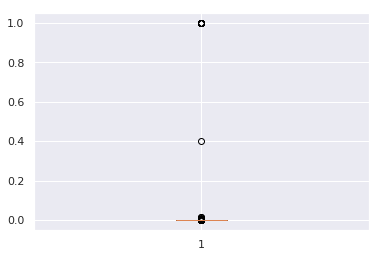

In [107]:
plt.boxplot(scores)

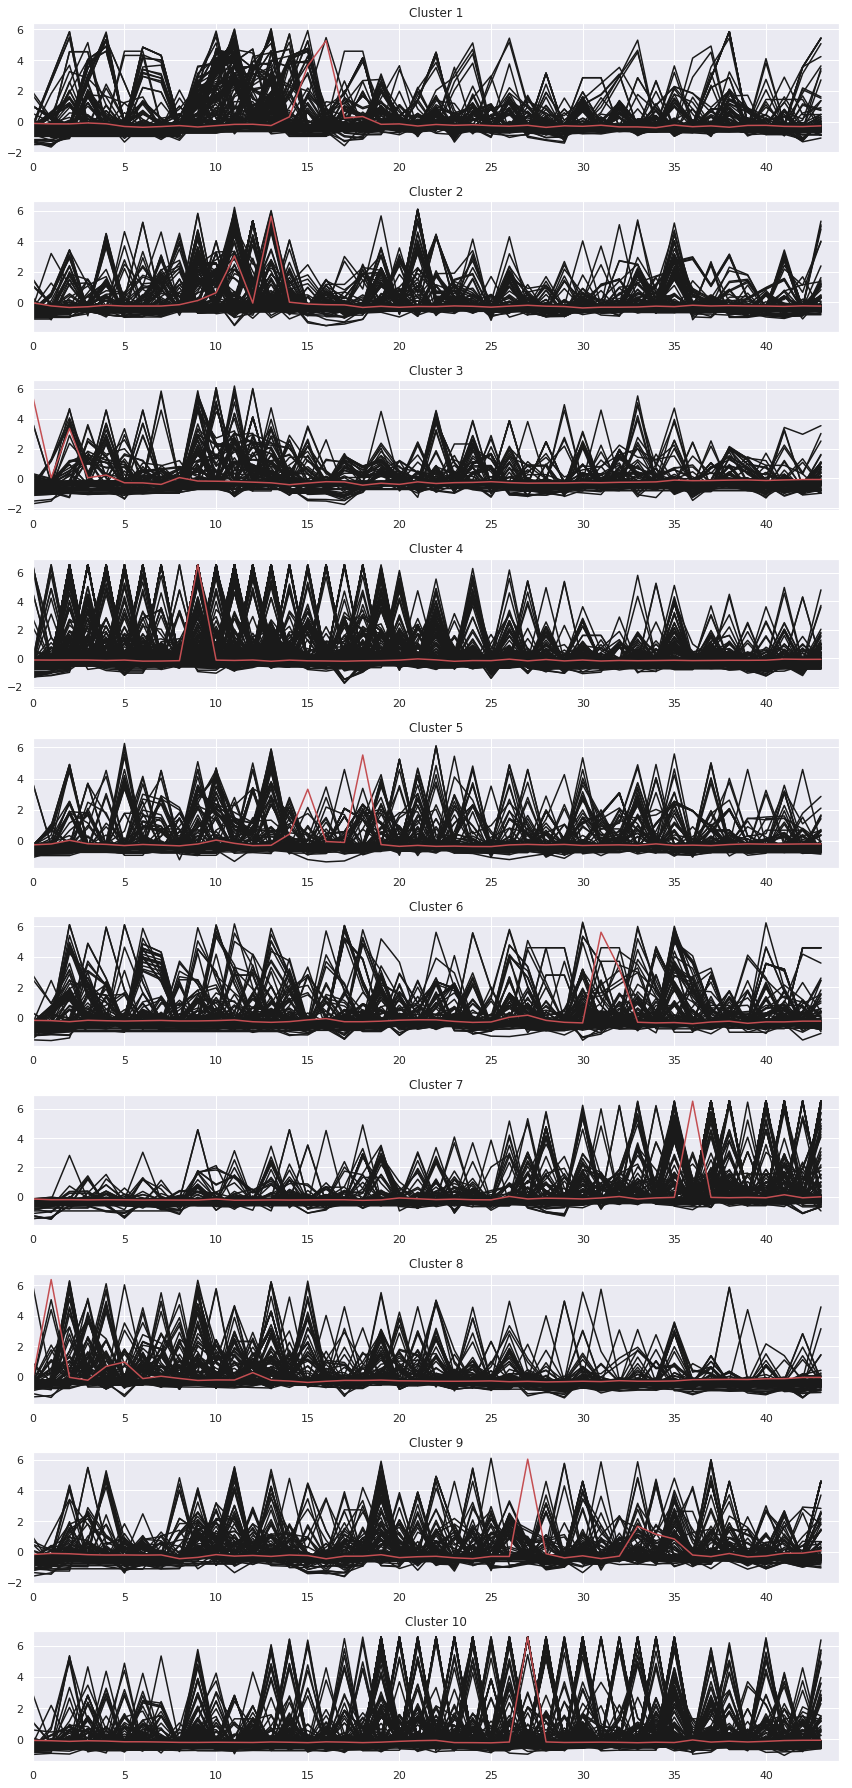

In [108]:
plot_data(ks, X_train, y_pred, sz, 10)

In [59]:
ks.cluster_centers_[0].ravel()

array([-0.10349802, -0.14129419, -0.13960461, -0.06559617, -0.11924003,
       -0.27325071, -0.33315701, -0.28652649, -0.24685199, -0.32066825,
       -0.23221525, -0.15834306, -0.14226948, -0.21788886,  0.20152472,
        3.59353014,  5.33678224,  0.2709727 ,  0.03331798, -0.17859744,
       -0.15509341, -0.28652059, -0.19251313, -0.26288582, -0.22403655,
       -0.27603651, -0.27706745, -0.20372704, -0.35919093, -0.26894938,
       -0.28483503, -0.21183989, -0.30460145, -0.32864232, -0.36049532,
       -0.21878298, -0.30025251, -0.26703584, -0.34568531, -0.22733383,
       -0.25752114, -0.28965257, -0.30372845, -0.27069875])

In [63]:
ks.labels_[1]

3